In [6]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely
from shapely import plotting
from sklearn.cluster import DBSCAN

### Prepare Data

In [7]:
# Load datasets
pois = pd.read_csv('data\POIs\POI_4815075.csv')
names = gpd.read_file('data\STREETS_NAMING_ADDRESSING\SREETS_NAMING_ADDRESSING_4815075.geojson')
nav = gpd.read_file('data\STREETS_NAV\SREETS_NAV_4815075.geojson')

# Combine Linestring geometry datasets
combined_map = pd.merge(nav, names, how='inner', on='link_id')
combined_map.drop(columns=['geometry_x'], inplace=True)
combined_map.rename(columns={'geometry_y': 'geometry'}, inplace=True)

# Sort DataFrame by street name
combined_map.sort_values(by='ST_NAME', inplace=True)

# Reset index
combined_map.reset_index(drop=True, inplace=True)
map_data = pd.DataFrame(names['ST_NAME'].value_counts())
map_data['ST_NAME'] = map_data.index
relevant_streets = map_data[:300][:]
point_map = gpd.GeoDataFrame()

point_maps = []
street_names = []

# Point maps
for i in relevant_streets['ST_NAME']:
    example = names.loc[names["ST_NAME"] == i]
    street_names.append(i)
    lst = [example.geometry.boundary.extract_unique_points()]
    point_map = gpd.GeoDataFrame( pd.concat( lst, ignore_index=True) )
    point_map = point_map.rename(columns={point_map.columns[0]: 'geometry'})
    point_map.set_geometry('geometry', inplace=True)
    point_map = point_map.explode(index_parts=False).reset_index(drop=True)
    point_maps.append(point_map)

### DBScan Clustering

In [61]:
# Create individual dataset from streets with the same name dataset

def st_nodes_dbscan(point_map, st_name,  eps:float = 0.5, min_samples:int = 1):
    """
    Returns the labels for each point provided in the geometry column of the point_map GeoDataFrame.
    The labels are generated using the DBSCAN clustering algorithm.
    input:
        point_map: GeoDataFrame
            A GeoDataFrame containing a geometry column with points to be clustered.
        eps: float
            The maximum distance between two samples for one to be considered in the neighborhood of the other.
            Default is 0.5.
        min_samples: int
            The number of samples in a neighborhood for a point to be considered as a core point.
            Default is 5.
    output:
        list of labels: list
            A list of labels for each point in the geometry column of the point_map GeoDataFrame.
    """
    st_name = st_name
    data = pd.DataFrame(
        {
            'x': [],
            'y': [],
        }
    )
    d = {'x': [], 'y': []}
    for j in point_map['geometry']:
        d['x'].append(j.x)
        d['y'].append(j.y)
    data = pd.DataFrame(d)
    data['x'] = data['x'].astype(float)
    data['y'] = data['y'].astype(float)
    # Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    data['cluster'] = dbscan.labels_
    data['cluster'] = data['cluster'].astype('category')
    plt.figure(figsize=(10, 10))
    plt.scatter(data['x'], data['y'], c=data['cluster'], s=40)
    plt.title(f"DBSCAN Clustering for {st_name}")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    #plt.figlegend('Cluster Label')
    plt.show()
    return data['cluster'].tolist()
    

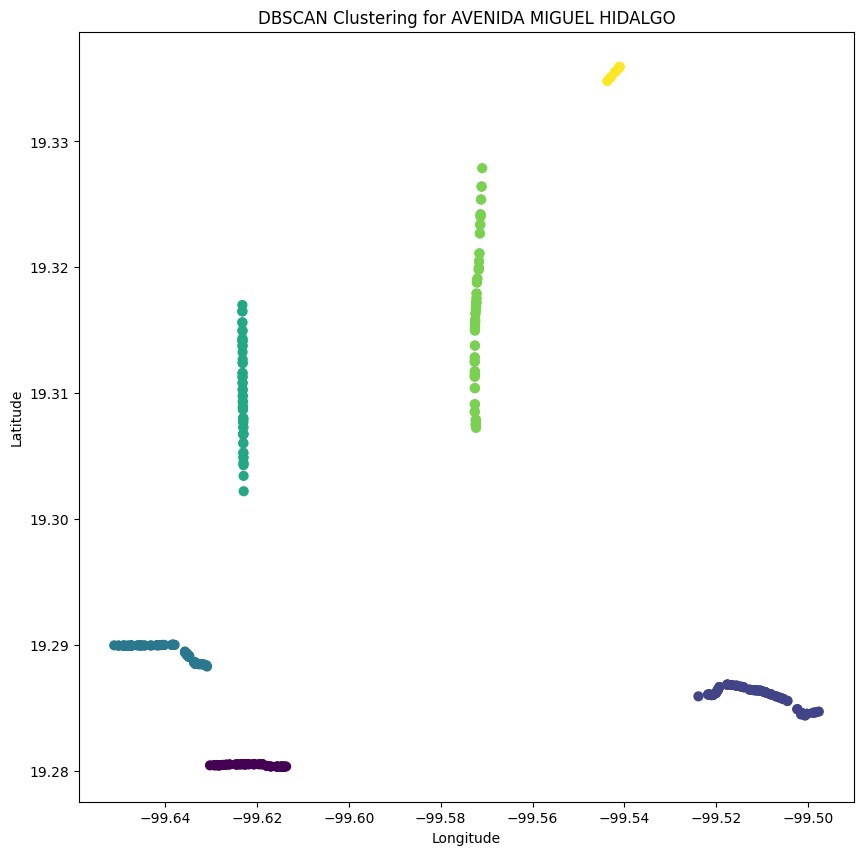

Labels:  [0 1 2 3 4 5]


In [62]:
labels = st_nodes_dbscan(point_maps[7],street_names[7], eps=0.005);
print("Labels: ", np.unique(np.array(labels)))

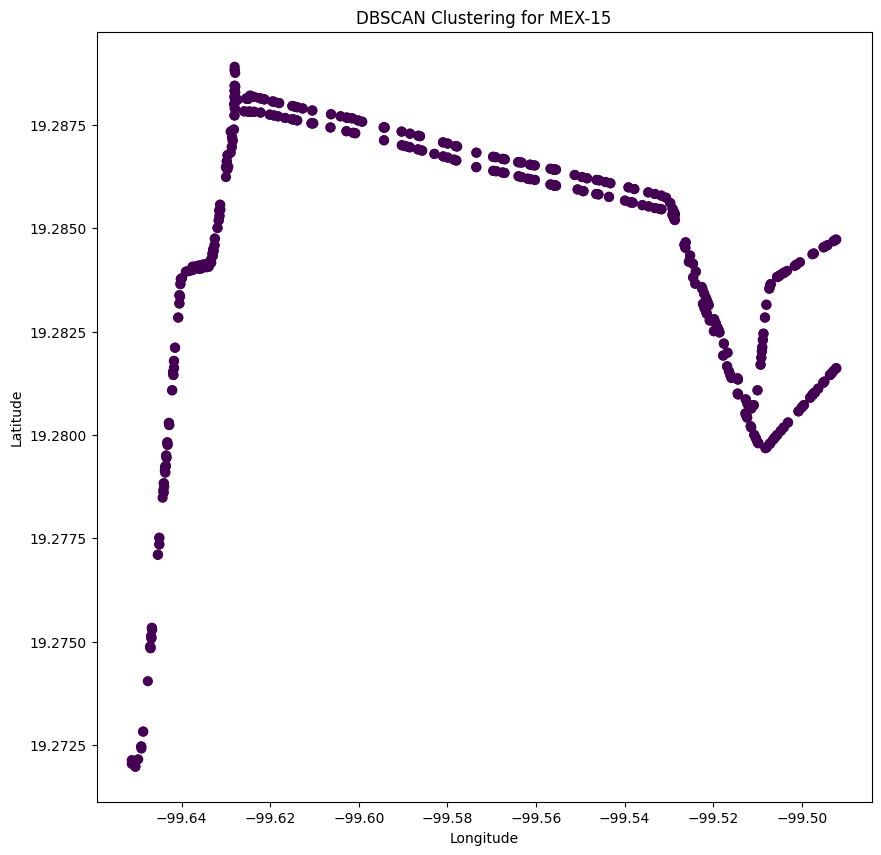

Labels:  [0]


In [63]:
labels = st_nodes_dbscan(point_maps[2],street_names[2], eps=0.005);
print("Labels: ", np.unique(np.array(labels)))

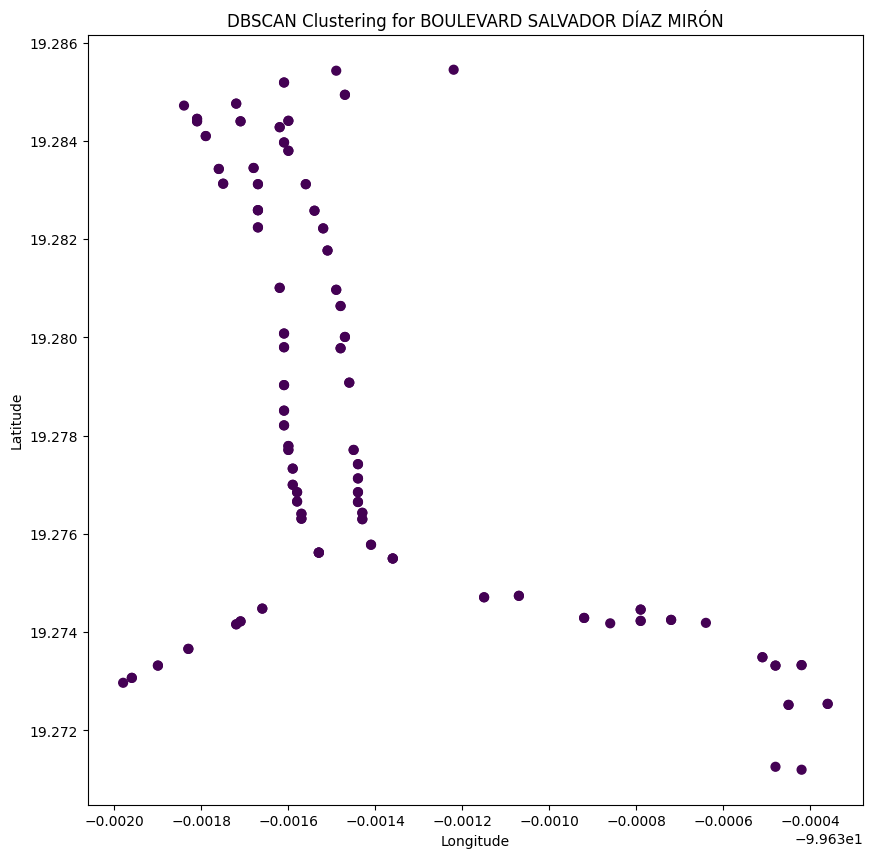

Labels:  [0]


In [64]:
labels = st_nodes_dbscan(point_maps[35],street_names[35], eps=0.005, min_samples=3);
print("Labels: ", np.unique(np.array(labels)))